Тема: Линеаризация и дельта-метод

Видео лекции:  
https://www.youtube.com/watch?v=SymKn7KFYKk
    
Видео семинара:  
https://www.youtube.com/watch?v=0QGRAQw4zwM

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import ttest_ind, norm, lognorm, bernoulli
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Настройки для красивых графиков
plt.rcParams['font.size'] = 16

# Ratio-метрики и линеаризация

## Генерация данных о сессиях пользователей

Будем генерировать пользователей со случайным кол-вом сессеий от 3 до 9. У каждого пользователя будет своя средняя длина сессии, множество сессий пользователя будет генерироваться просто добавлением шума к средней длине сессии пользователя.

In [3]:
def get_session_duration(size, effect=0, seed=None):
    """Генерирует данные с продолжительностями сессий.
    
    size: int, количество пользователей.
    effect: float, размер эффекта, на сколько изменилась продолжительность сессии относительно базовой.
    seed: int, состоянеие генератора случайных чисел
    
    return: List[np.array], список массивов,
        элемент списка - пользователь,
        элементы массива - длины сессий.
    """
    def _user_session(mean):
        n_session = np.random.randint(3, 9)
        sessions = np.random.normal(loc=mean, scale=10, size=n_session).astype(int)
        sessions = np.where(sessions >= 0, sessions, 0)
        return sessions
        
    if seed:
        np.random.seed(seed)
    
    # Генерация средней длины сессии для каждого пользователя + эффект
    mean_durations = np.random.normal(loc=100, scale=20, size=size) * (1 + effect)
    
    # Список длин сессий по пользователям (список списков)
    return [_user_session(mean_duration) for mean_duration in mean_durations]

Посмотрим, как работает функция генерации данных

In [4]:
get_session_duration(size=5, effect=0, seed=None)

[array([86, 70, 97, 73, 74, 86, 84]),
 array([89, 83, 79, 76, 69, 89]),
 array([ 98, 120,  87, 105]),
 array([76, 71, 82, 75, 86, 79]),
 array([127, 150, 144, 137, 161, 142])]

## 1. АА-тест и распределение p-value

Корректно работающий статистический тест дает равномерное распределение p-value для АА-теста. Действительно, p-value показывает вероятность получить такое же или большее значение статистики при справедливости нулевой гепотезы. Из этого автоматически следует выше написанное утверждение.

In [5]:
def plot_value_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    if title:
        plt.suptitle(title)
    
    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0, 1], [1, 1], 'k--')
    ax1.set_xlabel('P-value')
    
    sns.ecdfplot(pvalues, ax=ax2)
    ax2.set_xlabel('P-value')
    ax2.set_ylabel('Probability')
    ax2.grid()

Проверим наши рассуждения на примере нормального распределения:

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 3898.83it/s]


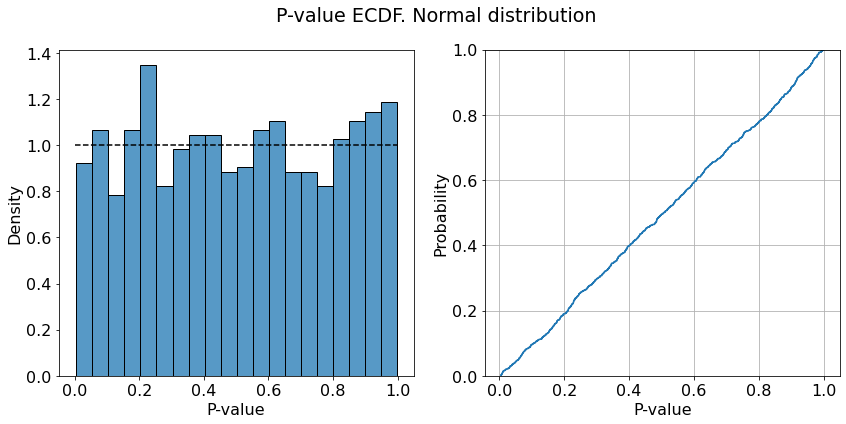

In [6]:
def get_pvalue_samples(a_generator, b_generator, size):
    pvalues = []
    for _ in tqdm(range(size)):
        _, pval = ttest_ind(a_generator(), b_generator())
        pvalues.append(pval)
    return pvalues

a_generator = lambda: np.random.normal(loc=0, scale=1, size=100)
b_generator = lambda: np.random.normal(loc=0, scale=1, size=100)

pvalues = get_pvalue_samples(a_generator, b_generator, size=1000)

plot_value_ecdf(pvalues, title='P-value ECDF. Normal distribution')

Наши ожидания оправдались. Мы видим распределение p-value близкое к равномерному.

## 2.Проблема зависимых случайных величин. Тест Стьюдента по сессиям

Посмотрим, что произойдет с тестом при наивном применении. Когда мы в качестве случайных величин возьмем длины сессий пользователей в пилотной и контрольной группах.

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 296.29it/s]


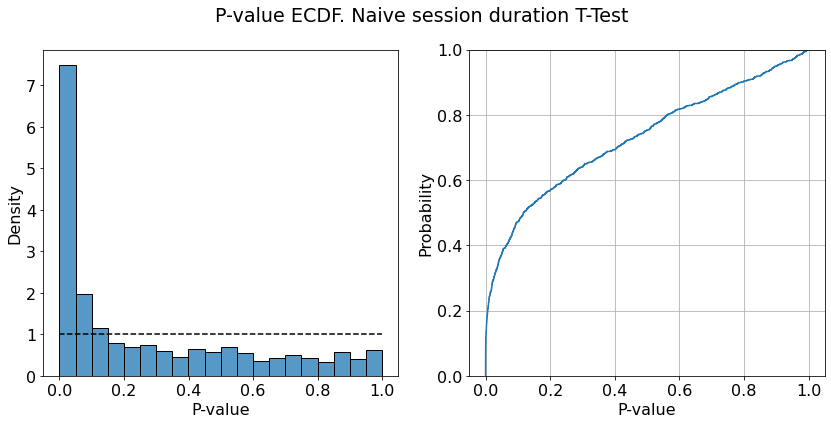

In [7]:
def check_test_naive(a, b):
    """Проверка гипотезы с помощью наивного среднего по длинам сессий.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    
    return: pvalue и точечную оценку.
    """
    a_naive = np.concatenate(a)
    b_naive = np.concatenate(b)
    delta = np.mean(b_naive) - np.mean(a_naive)
    _, pval = ttest_ind(a_naive, b_naive)
    return pval, delta

def naive_session_duration(size=100, effect=0):
    # Объединяем все сессии по пользователям в один массив
    def _duration():
        durations = get_session_duration(size=size, effect=effect)
        return np.concatenate(durations)
    return _duration

pvalues = get_pvalue_samples(naive_session_duration(size=100, effect=0),
                             naive_session_duration(size=100, effect=0),
                             size=1000)
        
plot_value_ecdf(pvalues, title='P-value ECDF. Naive session duration T-Test')      

Мы видим, что полученное распределение сильно неравномерное. Это говорит о неверно сконструированном тесте. 

pvalue < 0.05 примерно в 40% случаев, то есть в 40% случаев мы отклонили нулевую гипотезу, когда она была верна.

Всё это связано с тем, что длины сессий не будут независимыми. Для каждого пользователя вообще говоря будет свое распределение. И неравенство в выборе приводит к таким плачевным результатам.

## 3. Среднее по пользователям

Не всегда, но очень часто, мы можем предположить независимость действия отдельных пользователей. Поэтому и статистики для пользователей должны быть независимыми.

Посмотрим на распределение p-value для user average. А также выясним, сохраняется ли сонаправленность этой мерики с исходной (без усреднения по пользователям)

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 172.16it/s]


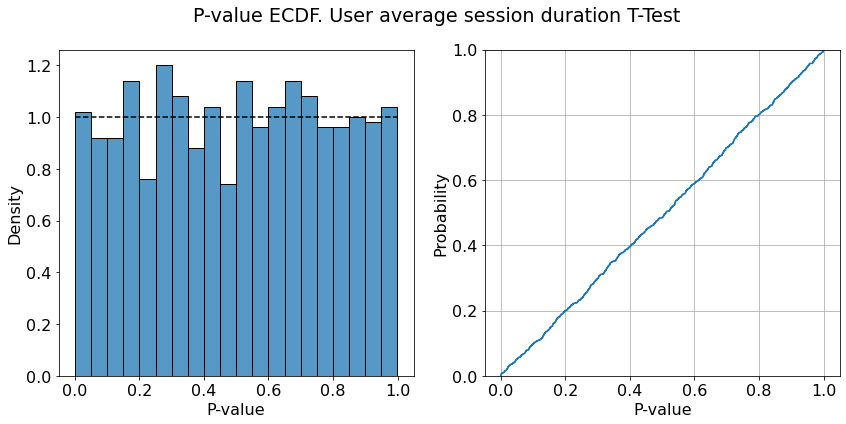

In [8]:
def check_test_avg(a, b):
    """Проверка гипотезы с помощью средней длины сессии каждого пользователя.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    
    return: pvalue и точечную оценку.
    """
    a_avg = [np.mean(s) for s in a]
    b_avg = [np.mean(s) for s in b]
    delta = np.mean(b_avg) - np.mean(a_avg)
    _, pval = ttest_ind(a_avg, b_avg)
    return pval, delta

def user_average_duration(size=100, effect=0):
    # Считаем среднюю длину сессии каждого пользователя
    def _duration():
        durations = get_session_duration(size=size, effect=effect)
        return [np.mean(s) for s in durations]
    return _duration

pvalues = get_pvalue_samples(user_average_duration(size=100, effect=0),
                             user_average_duration(size=100, effect=0),
                             size=1000)
        
plot_value_ecdf(pvalues, title='P-value ECDF. User average session duration T-Test')      

Сравним направленность метрик

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 180.22it/s]


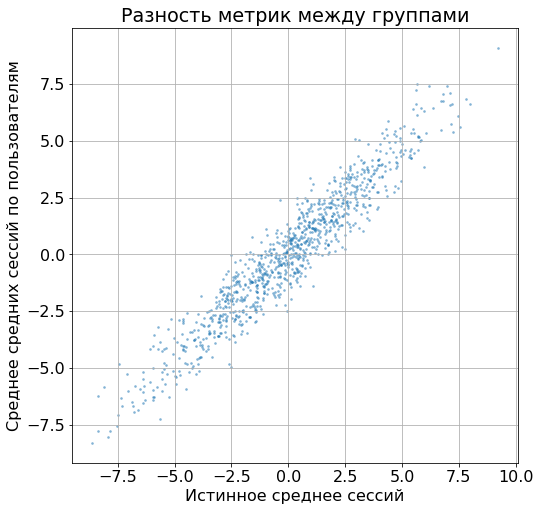

In [9]:
session_lens = []
avg_user_sessions_lens = []

def get_sessions_diffs(a, b):
    sa = np.concatenate(a)
    sb = np.concatenate(b)
    return np.mean(sb) - np.mean(sa)

def get_avg_user_sessions_diffs(a, b):
    sa = [np.mean(s) for s in a]
    sb = [np.mean(s) for s in b]
    return np.mean(sb) - np.mean(sa)

for _ in tqdm(range(1000)):
    a = get_session_duration(size=100)
    b = get_session_duration(size=100)
    session_lens.append(get_sessions_diffs(a, b))
    avg_user_sessions_lens.append(get_avg_user_sessions_diffs(a, b))
    
plt.figure(figsize=(8, 8))    
plt.scatter(session_lens, avg_user_sessions_lens, s=3, alpha=0.4)
plt.title('Разность метрик между группами')
plt.xlabel('Истинное среднее сессий')
plt.ylabel('Среднее средних сессий по пользователям')
plt.grid()
    

Видно, что в окрестности точки [0, 0] есть области (левее и выше, правее и ниже), где метрики разнонаправленны.

К тому же сами метрики скоррелированы не идеально (относительно других примеров)

 ## 4. Бутстреп

Будем сэмплировать пользователей из групп и считать разность RATIO метрики

In [10]:
def check_bootstrap(a, b, n=1000):
    
    # Подготовка: для каждого клиента посчитаем сумму длин сессий их кол-во
    a_prep_sum = np.array([np.sum(s) for s in a])
    b_prep_sum = np.array([np.sum(s) for s in b])
    a_prep_count = np.array([len(s) for s in a])
    b_prep_count = np.array([len(s) for s in b])
    
    # Истинная оценка
    delta = np.sum(b_prep_sum) / np.sum(b_prep_count) - np.sum(a_prep_sum) / np.sum(a_prep_count)
    
    # Массив разниц
    bootstrap_deltas = []
    for _ in range(n):
        a_idx = np.random.choice(np.arange(len(a)), size=len(a), replace=True)
        b_idx = np.random.choice(np.arange(len(b)), size=len(b), replace=True)
        bootstrap_delta = np.sum(b_prep_sum[b_idx]) / np.sum(b_prep_count[b_idx]) \
                            - np.sum(a_prep_sum[a_idx]) / np.sum(a_prep_count[a_idx])
        bootstrap_deltas.append(bootstrap_delta)

    # Бутстреп-оценка
    bootstrap_delta = np.mean(bootstrap_deltas)
    # СКО бутстреп оценок
    std_bootstrap_deltas = np.std(bootstrap_deltas)
    
    pvalue = 2 * (1 - norm.cdf(np.abs(delta) / std_bootstrap_deltas))
    
    return pvalue, delta
    

Проверим наличие у этого способа недостатков прошлых методов: неравномерность pvalue на АА-тесте и сонаправленность.

In [11]:
true_deltas = []
bootstrap_deltas = []
pvalues = []

for _ in tqdm(range(1000)):
    a = get_session_duration(size=100, effect=0)
    b = get_session_duration(size=100, effect=0)
    true_delta = np.mean(np.concatenate(b)) - np.mean(np.concatenate(a))
    pvalue, delta = check_bootstrap(a, b)
    true_deltas.append(true_delta)
    bootstrap_deltas.append(delta)
    pvalues.append(pvalue)

100%|███████████████████████████████████████| 1000/1000 [01:08<00:00, 14.66it/s]


/home/lucky/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

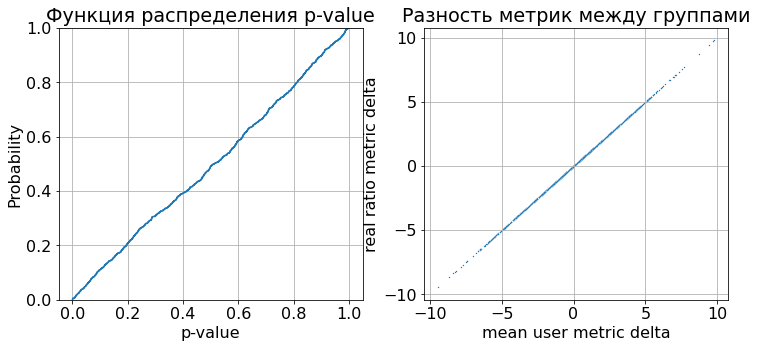

In [12]:
def plot_two_graph(list_pvalue, list_delta, list_real_delta, suptitle=None):
    if suptitle:
        plt.suptitle(suptitle)
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])
    
    sns.ecdfplot(list_pvalue, ax=ax1)
    ax1.set_xlabel('p-value')
    ax1.set_ylabel('Probability')
    ax1.set_title('Функция распределения p-value')
    ax1.grid()
    
    sns.scatterplot(list_delta, list_real_delta, s=2, ax=ax2)
    ax2.set_xlabel('mean user metric delta')
    ax2.set_ylabel('real ratio metric delta')
    ax2.set_title('Разность метрик между группами')
    ax2.grid()
    

plot_two_graph(pvalues, bootstrap_deltas, true_deltas, suptitle='АА-тест. Бутстреп')

P-value распределен равномерно, направленность сохраняется. Отметим, что время вычислений заметно увеличилось. 

Проверим, может ли этот тест уловить эффект. Увеличим длину сессий в группе В.

In [13]:
true_deltas = []
bootstrap_deltas = []
pvalues = []

for _ in tqdm(range(1000)):
    a = get_session_duration(size=100, effect=0)
    b = get_session_duration(size=100, effect=0.05)
    true_delta = np.mean(np.concatenate(b)) - np.mean(np.concatenate(a))
    pvalue, delta = check_bootstrap(a, b)
    true_deltas.append(true_delta)
    bootstrap_deltas.append(delta)
    pvalues.append(pvalue)

100%|███████████████████████████████████████| 1000/1000 [01:07<00:00, 14.73it/s]


/home/lucky/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

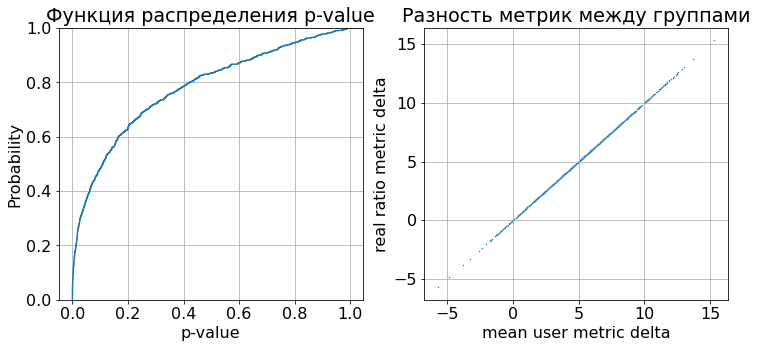

In [14]:
plot_two_graph(pvalues, bootstrap_deltas, true_deltas, suptitle='АB-тест с эффектом. Бутстреп')

Видно, что распределение p-value сместилось ближе к нулю. То есть нулевая гипотеза стала отвергаться чаще.

## 5. Дельта-метод

Реализуем дельта-метод

In [15]:
def check_delta_method(a, b):
    
    def prep_components(a):
        d = dict()
        d['x'] = [np.sum(s) for s in a]
        d['y'] = [len(s) for s in a]
        d['mean_x'] = np.mean(d['x'])
        d['mean_y'] = np.mean(d['y'])
        d['std_x'] = np.std(d['x'])
        d['std_y'] = np.std(d['y'])
        d['cov_xy'] = np.cov(d['x'], d['y'])[0, 1]
        
        d['metric'] = np.sum(d['x']) / np.sum(d['y'])
        d['metric_var'] = (
            d['std_x'] ** 2 / d['mean_y'] ** 2 \
            + d['mean_x'] ** 2 / d['mean_y'] ** 4 * d['std_y'] ** 2 \
            - 2 * d['mean_x'] / d['mean_y'] ** 3 * d['cov_xy']
        ) / len(a)
        return d
    
    d_a = prep_components(a)
    d_b = prep_components(b)
    
    var = d_a['metric_var'] + d_b['metric_var']
    delta = d_b['metric'] - d_a['metric']
    pvalue = 2 * (1 - norm.cdf(np.abs(delta) / np.sqrt(var)))
    
    return pvalue, delta

Проведем проверки, аналогичные бутстрепу

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 243.15it/s]
/home/lucky/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


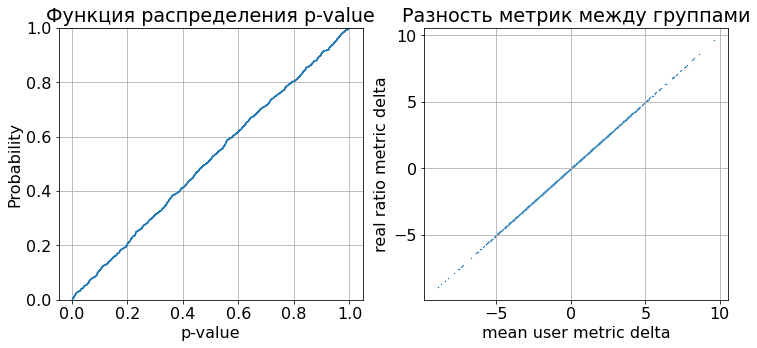

In [16]:
true_deltas = []
bootstrap_deltas = []
pvalues = []

for _ in tqdm(range(1000)):
    a = get_session_duration(size=100, effect=0)
    b = get_session_duration(size=100, effect=0)
    true_delta = np.mean(np.concatenate(b)) - np.mean(np.concatenate(a))
    pvalue, delta = check_delta_method(a, b)
    true_deltas.append(true_delta)
    bootstrap_deltas.append(delta)
    pvalues.append(pvalue)
    
plot_two_graph(pvalues, bootstrap_deltas, true_deltas)

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 242.81it/s]
/home/lucky/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


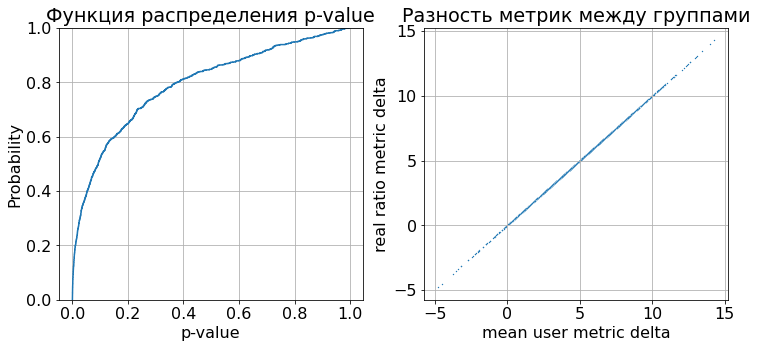

In [17]:
true_deltas = []
bootstrap_deltas = []
pvalues = []

for _ in tqdm(range(1000)):
    a = get_session_duration(size=100, effect=0)
    b = get_session_duration(size=100, effect=0.05)
    true_delta = np.mean(np.concatenate(b)) - np.mean(np.concatenate(a))
    pvalue, delta = check_delta_method(a, b)
    true_deltas.append(true_delta)
    bootstrap_deltas.append(delta)
    pvalues.append(pvalue)
    
plot_two_graph(pvalues, bootstrap_deltas, true_deltas)

Получаем ожидаемые и корректные результаты

## 6. Линеаризация

In [18]:
def check_linearization(a, b):
    a_x = np.array([np.sum(s) for s in a])
    b_x = np.array([np.sum(s) for s in b])
    a_y = np.array([len(s) for s in a])
    b_y = np.array([len(s) for s in b])
    coef = np.sum(a_x) / np.sum(a_y)
    a_lin = a_x - coef * a_y
    b_lin = b_x - coef * b_y
    _, pvalue = ttest_ind(a_lin, b_lin, equal_var=False)
    delta = np.mean(b_lin) - np.mean(a_lin)
    return pvalue, delta

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 256.64it/s]
/home/lucky/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


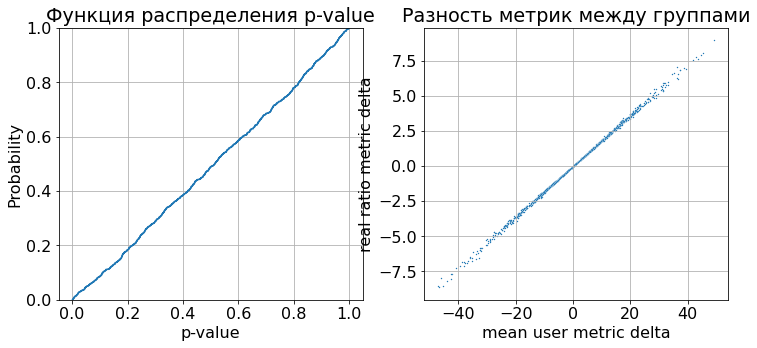

In [19]:
true_deltas = []
bootstrap_deltas = []
pvalues = []

for _ in tqdm(range(1000)):
    a = get_session_duration(size=100, effect=0)
    b = get_session_duration(size=100, effect=0)
    true_delta = np.mean(np.concatenate(b)) - np.mean(np.concatenate(a))
    pvalue, delta = check_linearization(a, b)
    true_deltas.append(true_delta)
    bootstrap_deltas.append(delta)
    pvalues.append(pvalue)
    
plot_two_graph(pvalues, bootstrap_deltas, true_deltas)

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 265.06it/s]
/home/lucky/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


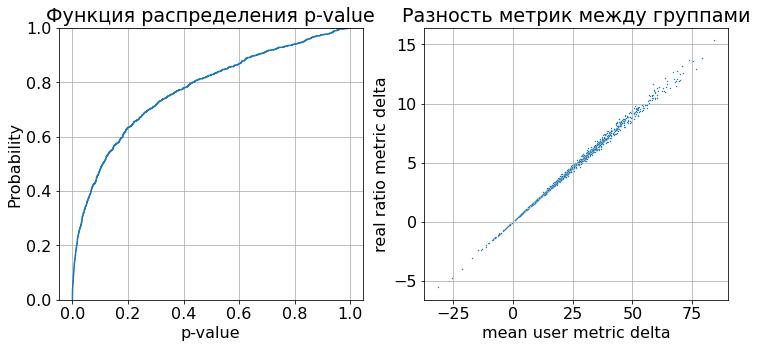

In [20]:
true_deltas = []
bootstrap_deltas = []
pvalues = []

for _ in tqdm(range(1000)):
    a = get_session_duration(size=100, effect=0)
    b = get_session_duration(size=100, effect=0.05)
    true_delta = np.mean(np.concatenate(b)) - np.mean(np.concatenate(a))
    pvalue, delta = check_linearization(a, b)
    true_deltas.append(true_delta)
    bootstrap_deltas.append(delta)
    pvalues.append(pvalue)
    
plot_two_graph(pvalues, bootstrap_deltas, true_deltas)

Получаем ожидаемые и корректные результаты

## 7. Итого

Посмотрим на методы вместе. Будем генерировать данные и считать приращения метрик и pvalue всеми способами и отобразим полученные результаты на графиках.

In [21]:
dict_check = {
    'bootstrap': check_bootstrap,
    'naive':check_test_naive,
    'avg': check_test_avg,
    'delta': check_delta_method,
    'linearization': check_linearization,
}
res_dict = {method: {'pvalue': [], 'delta': []} for method in dict_check}

for _ in tqdm(range(200)):
    a = get_session_duration(size=100, effect=0)
    b = get_session_duration(size=100, effect=np.random.choice([-0.05, 0, 0.05]))
    for method_name, method_func in dict_check.items():
        pvalue, delta = method_func(a, b)
        res_dict[method_name]['pvalue'].append(pvalue)
        res_dict[method_name]['delta'].append(delta)

100%|█████████████████████████████████████████| 200/200 [00:14<00:00, 13.74it/s]


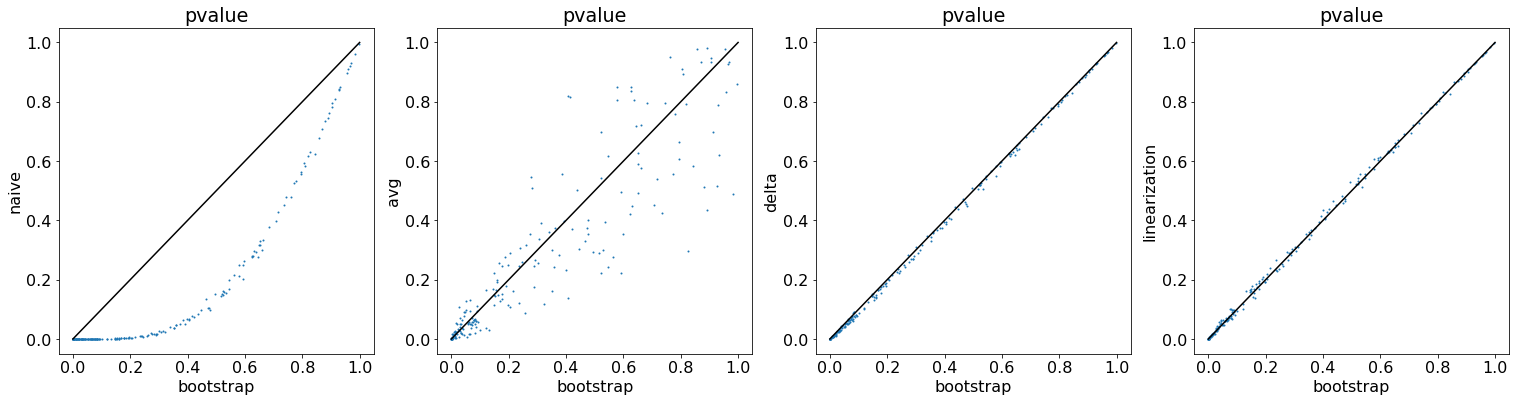

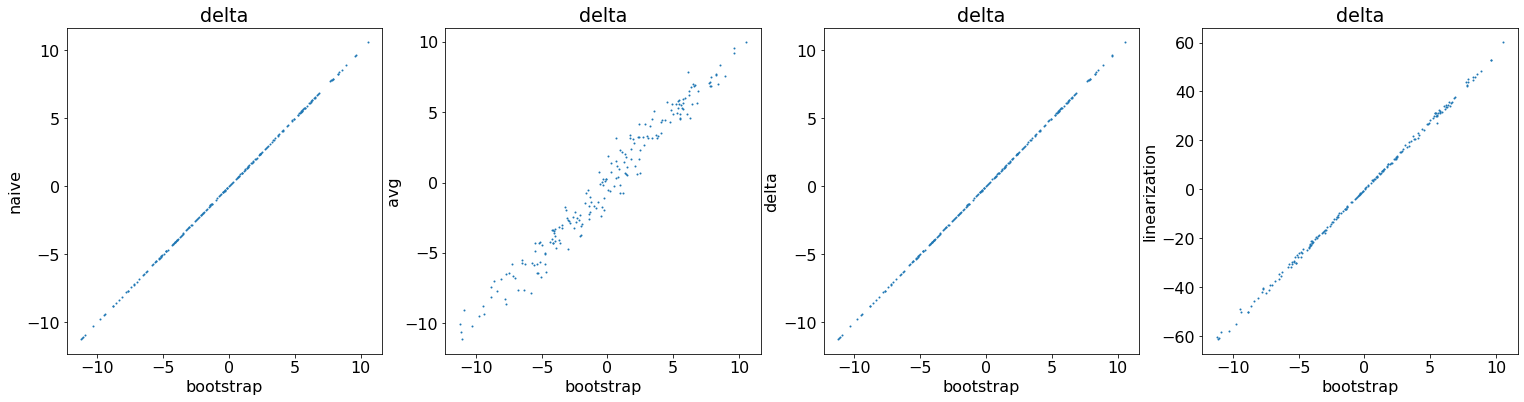

In [22]:
for data_type in ['pvalue', 'delta']:
    fig, axes = plt.subplots(1, len(dict_check) - 1, figsize=[26, 6])
    i = 0
    for method in dict_check:
        # Строим графики относительно bootstrap, поэтому пропускаем
        if method == 'bootstrap':
            continue
        axes[i].scatter(res_dict['bootstrap'][data_type], res_dict[method][data_type], s=1)
        if data_type == 'pvalue':
            axes[i].plot([0, 1], [0, 1], 'k')
        axes[i].set_xlabel('bootstrap')
        axes[i].set_ylabel(method)
        axes[i].set_title(data_type)
        i += 1

В верхнем ряду графики для pvalue, в нижнем - для разности метрик. По оси обсцисс везде бутстреп, по оси ординат другие методы.

Видно, что первые два метода отличаются от остальных и дают некорректные pvalue.

Результаты бутстрепа, дельта-метода и линеаризации оень похожи. Но бутстреп плох сложностью вычислений, которые занимают много времени. Плюс линеаризации под дельта-методом в наличии пользовательской метрики. Давайте придумаем пример, где это может дать преимущество.

## 8. Дельта-метод VS линеаризация

Нам понадобятся данные о пользовательских сессиях до пилота. Пусть там будет слечайное кол-во сессий от 3 до 9, но точно такое же среднее значение продолжительности сессий

In [23]:
def get_session_duration_with_prepilot(size, effect=0, seed=None):
    """
    Тоже самое, что и set_session_duration(), только возвращает 2 набора данных:
    для каждого пользователя точно такая же средняя продолжительность сессий,
    но кол-во сессий случайное
    """
    def _user_session(mean):
        n_session = np.random.randint(3, 10)
        sessions = np.random.normal(loc=mean, scale=10, size=n_session).astype(int)
        sessions = np.where(sessions >= 0, sessions, 0)
        return sessions
        
    if seed:
        np.random.seed(seed)
    
    # Генерация средней длины сессии для каждого пользователя без эффекта (препилот)
    mean_durations_no_effect = np.random.normal(loc=100, scale=20, size=size)
    # Добавляю эффект для пилота
    mean_durations_effect = mean_durations_no_effect * (1 + effect)
    
    # Список длин сессий по пользователям (список списков)
    data_effect = [_user_session(mean_duration) for mean_duration in mean_durations_effect]
    data_no_effect = [_user_session(mean_duration) for mean_duration in mean_durations_no_effect]
    
    return data_effect, data_no_effect

In [24]:
# Тестовая генерация
get_session_duration_with_prepilot(size=3, effect=0.2)

([array([150, 157, 159, 149, 152, 138, 158]),
  array([117, 105, 120]),
  array([120, 134, 140, 115, 123, 148])],
 [array([137, 111, 124, 121, 128, 109, 116, 104, 120]),
  array([91, 98, 88, 99, 67]),
  array([100, 134, 101,  89,  93])])

Сгенерируем данные для пилотной и контрольной групп

In [25]:
size = 10_000
np.random.seed(23)
effect = 0.007

data_pilot, data_pilot_before = get_session_duration_with_prepilot(size=size, effect=effect)
data_control, data_control_before = get_session_duration_with_prepilot(size=size, effect=0)

Посчитаем pvalue с помощью дельта-метода и линеаризации

In [26]:
pvalue, delta = check_delta_method(data_control, data_pilot)
print(f'pvalue delta method {pvalue:0.4f}')

pvalue, delta = check_linearization(data_control, data_pilot)
print(f'pvalue linearization {pvalue:0.4f}')

pvalue delta method 0.3994
pvalue linearization 0.3985


Оба метода не отвергли нулевую гипотезу на уровне значимости 0.05.  
Для линеаризации мы имеем пользовательскую метрику.  
Можем применить способ понижения дисперсии CUPED

In [27]:
df_pilot = pd.DataFrame({'x': [np.sum(s) for s in data_pilot],
                        'y': [len(s) for s in data_pilot],
                        'x_before': [np.sum(s) for s in data_pilot_before],
                        'y_before': [len(s) for s in data_pilot_before],
                        })

df_control = pd.DataFrame({'x': [np.sum(s) for s in data_control],
                        'y': [len(s) for s in data_control],
                        'x_before': [np.sum(s) for s in data_control_before],
                        'y_before': [len(s) for s in data_control_before],
                        })
coef_lin = df_control['x'].sum() / df_control['y'].sum()
df_pilot['metric_lin'] = df_pilot['x'] - coef_lin * df_pilot['y']
df_control['metric_lin'] = df_control['x'] - coef_lin * df_control['y']
df_pilot['metric_lin_before'] = df_pilot['x_before'] - coef_lin * df_pilot['y_before']
df_control['metric_lin_before'] = df_control['x_before'] - coef_lin * df_control['y_before']

df_pilot

,x,y,x_before,y_before,metric_lin,metric_lin_before
0,838,8,685,6,42.946588,88.709941
1,704,7,691,7,8.328265,-4.671735
2,820,9,782,9,-74.435088,-112.435088
3,333,3,339,3,34.854971,40.854971
4,686,6,534,5,89.709941,37.091618
...,...,...,...,...,...,...
9995,300,4,695,9,-97.526706,-199.435088
9996,371,6,477,7,-225.290059,-218.671735
9997,1047,8,867,7,251.946588,171.328265
9998,627,5,1086,9,130.091618,191.564912


In [28]:
_, pval = ttest_ind(df_pilot['metric_lin'], df_control['metric_lin'])
pval

0.39846816728883516

P-value совпадает с полученным ранее значением

### CUPED
Применим CUPED к линеаризованной метрике

In [29]:
def calculate_theta(y_control, y_pilot, y_control_cov, y_pilot_cov) -> float:
    y = np.concatenate([y_control, y_pilot])
    y_cov = np.concatenate([y_control_cov, y_pilot_cov])
    cov = np.cov(y_cov, y)[0, 1]
    var = y_cov.var()
    theta = cov / var
    return theta

theta = calculate_theta(df_control['metric_lin'],
                        df_pilot['metric_lin'],
                        df_control['metric_lin_before'],
                        df_pilot['metric_lin_before'])
theta

0.8686633864424133

In [30]:
df_pilot['metric_lin_cuped'] = df_pilot['metric_lin'] - theta * df_pilot['metric_lin_before']
df_control['metric_lin_cuped'] = df_control['metric_lin'] - theta * df_control['metric_lin_before']

Проверим, сохраняется ли сонаправленность точечных оценок.

In [31]:
delta = df_pilot['x'].sum() / df_pilot['y'].sum() \
            - df_control['x'].sum() / df_control['y'].sum()
delta_lin = df_pilot['metric_lin'].mean() - df_control['metric_lin'].mean()
delta_lin_cuped = df_pilot['metric_lin_cuped'].mean() - df_control['metric_lin_cuped'].mean()

print(f"Эффект по обычной метрике: {delta:.4f}")
print(f"Эффект по линеаризованной метрике: {delta_lin:.4f}")
print(f"Эффект по линеаризованной cuped метрике: {delta_lin_cuped:.4f}")

Эффект по обычной метрике: 0.2568
Эффект по линеаризованной метрике: 1.5457
Эффект по линеаризованной cuped метрике: 4.3948


In [32]:
_, pval = ttest_ind(df_control['metric_lin_cuped'], df_pilot['metric_lin_cuped'])
pval

1.4530097488335832e-06

Получили pvalue < 0.05, то есть виден значимый эффект на уровне значимости 5%

### АА-тест: Проверка корректности работы линеаризации + cuped
Делаем все тоже самое, но без эффекта в пилотной группе

In [33]:
pvals = []
for _ in tqdm(range(100)):
    data_pilot, data_pilot_before = get_session_duration_with_prepilot(size=size, effect=0)
    data_control, data_control_before = get_session_duration_with_prepilot(size=size, effect=0)

    df_pilot = pd.DataFrame({'x': [np.sum(s) for s in data_pilot],
                            'y': [len(s) for s in data_pilot],
                            'x_before': [np.sum(s) for s in data_pilot_before],
                            'y_before': [len(s) for s in data_pilot_before],
                            })

    df_control = pd.DataFrame({'x': [np.sum(s) for s in data_control],
                            'y': [len(s) for s in data_control],
                            'x_before': [np.sum(s) for s in data_control_before],
                            'y_before': [len(s) for s in data_control_before],
                            })
    coef_lin = df_control['x'].sum() / df_control['y'].sum()
    df_pilot['metric_lin'] = df_pilot['x'] - coef_lin * df_pilot['y']
    df_control['metric_lin'] = df_control['x'] - coef_lin * df_control['y']
    df_pilot['metric_lin_before'] = df_pilot['x_before'] - coef_lin * df_pilot['y_before']
    df_control['metric_lin_before'] = df_control['x_before'] - coef_lin * df_control['y_before']

    theta = calculate_theta(df_control['metric_lin'],
                            df_pilot['metric_lin'],
                            df_control['metric_lin_before'],
                            df_pilot['metric_lin_before'])

    df_pilot['metric_lin_cuped'] = df_pilot['metric_lin'] - theta * df_pilot['metric_lin_before']
    df_control['metric_lin_cuped'] = df_control['metric_lin'] - theta * df_control['metric_lin_before']
    _, pval = ttest_ind(df_control['metric_lin_cuped'], df_pilot['metric_lin_cuped'])
    pvals.append(pval)

100%|█████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


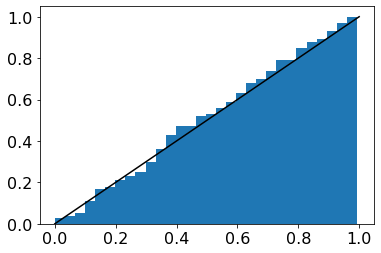

In [34]:
plt.hist(pvals, bins=30, density=True, cumulative=True)
plt.plot([0, 1], [0, 1], color='k')

## Метод бакетов. Как избавиться от зависимости в данных?

Проведем модельный эксперимент. Пусть для каждого магазина мы выберем 500 пользователей для теста и контроля. Каждый из них может с определенной вероятностью прийти в какой-то из дней в магазин. Если он пришел в магазин, то потратит там какую-то случайную сумму.  

Проанализируем ежедневную выручку для 10 магазинов в пилотной и 10 магазинов в контрольной группах. Чтобы набрать объем данных для тестирования, мы будем проводить эксперимент в течение 14 дней.  

В рамках эксперимента мы будем полагать, что каждый пришедщий покупатель потратит какую-то сумму, определеяемую логнормальным распределением. Для всех покупателей установим одинаковое среднее (1000) и среднеквадратичное отклонение (500). Дополнительно мы будем полагать, что каждый из покупателей приходит в магазин в среднем полтора раза в неделю.

In [35]:
from typing import Tuple

np.random.seed(0)

def get_dist_args(mean=1000, std=500) -> Tuple[float, float]:
    """
    Расчет параметров для логнормального распределения
    """
    k = (std / mean) ** 2 + 1
    s = -np.log(k / 2)
    scale = mean / k ** 0.5
    return s, scale
    
s, scale = get_dist_args(mean=1000, std=500)

# Логнормальное распределение с нужными параметрами
dist = lognorm(s=s, scale=scale)

def get_user_receipts():
    # Число дней в эксперименте
    SIZE = 14
    # Прийдет ли клиент в магазин в каждый из дней
    has_visited = bernoulli.rvs(p=1.5/7, size=SIZE)
    receipts = dist.rvs(size=SIZE)
    return has_visited * receipts

get_user_receipts()

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        , 1216.07849874,
       1342.74546857,    0.        , 2599.24530378,    0.        ,
          0.        ,  819.10019491])

На основе так сгенерированных чеков пользователямы можем построить распределение для магазинов. Пусть у нас как в пилотную, так и в контрольную группы попадают по 10 магазинов. В рамках модельного эксперимента сформируем UID пользователя (он нужен для воспроизводимости эксперимента)

In [36]:
def get_store_receipts():
    """
    Генерация всех чеков в магазине во время эксперимента
    """
    SIZE = (500, 14)
    has_visited = bernoulli.rvs(p=1.5/7, size=SIZE)
    receipts = dist.rvs(size=SIZE)
    return has_visited * receipts

def get_AB_groups(seed, receipts_generator=get_store_receipts):
    np.random.seed(seed)
    A = [receipts_generator() for _ in range(10)]
    B = [receipts_generator() for _ in range(10)]
    return A, B

a_receipts, b_receipts = get_AB_groups(0)

Для полученных групп проведем агрегацию и определим сумму ежедневных трат в каждом из магазинов

In [37]:
def get_daily_sales(group):
    """
    Продажи в группах по дням
    """
    return [shop_sales.sum(axis=0) for shop_sales in group]

/home/lucky/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/lucky/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


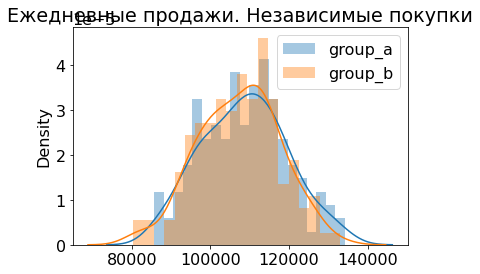

In [38]:
def plot_daily_sales_hist(group_a, group_b, title=None):
    daily_sales_a = get_daily_sales(group_a)
    daily_sales_b = get_daily_sales(group_b)
    
    if title:
        plt.title(title)
        
    sns.distplot(daily_sales_a, bins=20, label='group_a')
    sns.distplot(daily_sales_b, bins=20, label='group_b')
    plt.legend()
    
plot_daily_sales_hist(a_receipts, b_receipts, 'Ежедневные продажи. Независимые покупки')

Мы помним, что перед любым экспериментом нужно провести проверку равномерности pvalue в АА-тесте. Сейчас у нас как раз нет эффекта. Попробуем нарисовать график для распределения pvalue

100%|██████████████████████████████████████| 2000/2000 [00:17<00:00, 114.20it/s]


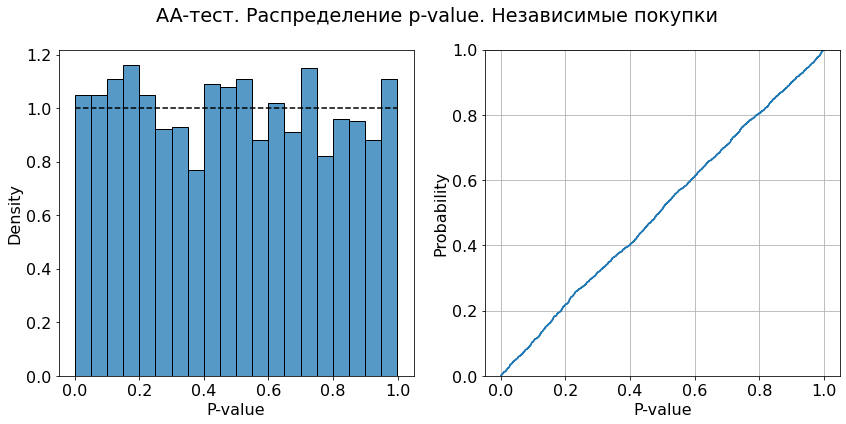

In [39]:
pvals = []
for i in tqdm(range(2000)):
    group_a, group_b = get_AB_groups(i)
    daily_sales_a = get_daily_sales(group_a)
    daily_sales_b = get_daily_sales(group_b)
    _, pval = ttest_ind(np.concatenate(daily_sales_a), np.concatenate(daily_sales_b))
    pvals.append(pval)
    
plot_value_ecdf(pvals, title='AA-тест. Распределение p-value. Независимые покупки')  

Вроде бы все хорошо.

Но давайте внимательно посмотрим на наш модельный эксперимент. Посмотрев внимательней, можно заметить, что в рамках эксперимента пользователи ведут себя день ото дня совершенно независимо. Действительно ли так ведут себя пользователи?

## Покупатели с любимым днем покупок

Чуть-чуть поменяем поведение пользователей. Пусть пользователи также в среднем приходят в магазин полтора раза в неделю. Но на этот раз у каждого из них будет любимый день покупок (он приходит в магазин с вероятностью 0.9), а в остальные дни приходит гораздо реже (вероятность покупки в магазине 0.1)

Изменим схему нашего эксперимента

In [40]:
def get_store_receipts_dependent():
    SHAPE=(500, 14)
    # Первоначальное заполнение матрицы вероятностей
    probs = np.full(shape=(SHAPE[0], SHAPE[1] // 2), fill_value=0.1)
    # Любимый день покупок
    favorite_days = np.random.randint(low=0, high=7, size=SHAPE[0])
    idx = [range(SHAPE[0]), favorite_days]
    probs[idx] = 0.9
    # Т.к. эксперимент длится 2 недели
    probs = np.concatenate([probs, probs], axis=1)
    
    has_visited = bernoulli.rvs(size=SHAPE, p=probs)
    receipts = dist.rvs(size=SHAPE)
    return has_visited * receipts

get_store_receipts_dependent()

/tmp/ipykernel_6397/2325914427.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs[idx] = 0.9


array([[ 868.76150297,    0.        ,    0.        , ...,    0.        ,
         714.97971254, 1016.27713316],
       [   0.        , 2854.36952366,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [1154.77621147,    0.        ,  893.74500755, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ..., 1396.48732507,
         538.52793043,    0.        ],
       [   0.        , 1083.48616005,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
        1243.54991323,    0.        ]])

/tmp/ipykernel_6397/2325914427.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs[idx] = 0.9
/home/lucky/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/lucky/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function f

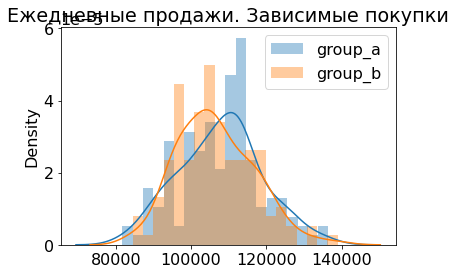

In [41]:
a_receipts_dep, b_receipts_dep = get_AB_groups(seed=0, receipts_generator=get_store_receipts_dependent)

plot_daily_sales_hist(a_receipts_dep, b_receipts_dep, "Ежедневные продажи. Зависимые покупки")

Убедимся, что сами по себе метрики не изменились

In [42]:
print('Независимые покупки:')
print('\tgroup_a:', round(np.sum(a_receipts)))
print('\tgroup_b:', round(np.sum(b_receipts)))

print('\nЗависимые покупки:')
print('\tgroup_a:', round(np.sum(a_receipts_dep)))
print('\tgroup_b:', round(np.sum(b_receipts_dep)))

Независимые покупки:
	group_a: 15208524
	group_b: 15020722

Зависимые покупки:
	group_a: 15089672
	group_b: 14901522


Наконец, мы можем проверить распределение p-value. Убедимся, что зависимость в данных ломает ttest

  0%|                                                  | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_6397/2325914427.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs[idx] = 0.9
100%|███████████████████████████████████████| 2000/2000 [00:27<00:00, 73.56it/s]


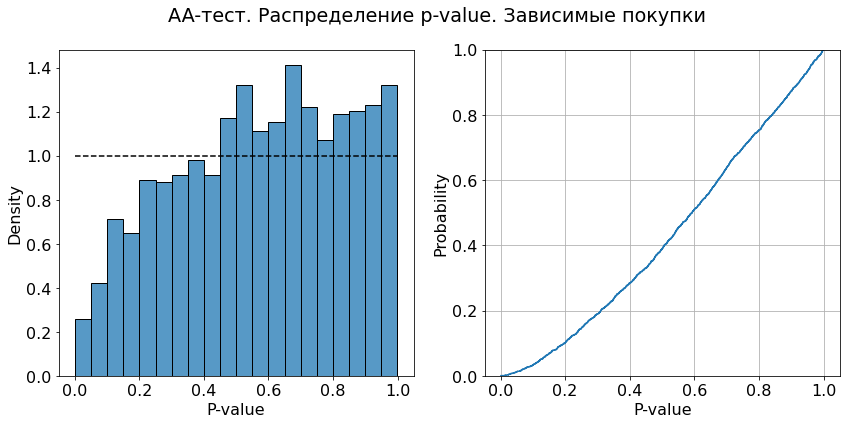

In [43]:
pvals = []
for i in tqdm(range(2000)):
    group_a, group_b = get_AB_groups(i, receipts_generator=get_store_receipts_dependent)
    daily_sales_a = get_daily_sales(group_a)
    daily_sales_b = get_daily_sales(group_b)
    _, pval = ttest_ind(np.concatenate(daily_sales_a), np.concatenate(daily_sales_b))
    # Можно делать без конкатенации. Тогда получим по 14 значений pvalue за 1 раз - по каждому дню отдельно
    # Но общий график по pvalue будет примерно такой же
    # _, pval = ttest_ind(daily_sales_a, daily_sales_b)
    pvals.append(pval)
    
plot_value_ecdf(pvals, title='AA-тест. Распределение p-value. Зависимые покупки')  

### Метод бакетов

Мы видим, что во внешне случайный процесс очень легко проникает зависимость между данными. И это ломает наши тесты. Давайте научимся бороться с этим.

Для этого прейдем от подсчета суточной выручки по магазинам к подсчету общей выручки, принесенной одним пользователем. Данные по пользователям агрегируем в несколько бакетов. Можно выбрать 100 бакетов и произвести объединение на основе хэша. В нашей модельной задаче мы просто объединим каждого сотого ползователя из эксперимента.

In [105]:
def get_bucket_sum(group):
    # Число бакетов
    B = 100
    bucket_sum = np.zeros(B)
    for shop_sales in group:
        # Суммарные продажи по пользователям за все дни
        user_sales = shop_sales.sum(axis=1)
        # Предполагаем, что поделится нацело
        n_split_parts = user_sales.shape[0] // B
        user_sales_splitted = np.array_split(user_sales, n_split_parts)
        # Суммы по каждому бакету
        bucket_sum = np.sum(user_sales_splitted, axis=0)
    return bucket_sum

/home/lucky/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/lucky/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


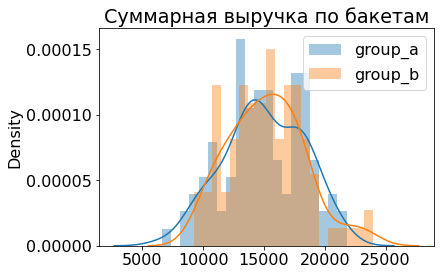

In [109]:
bucket_a_dep = get_bucket_sum(a_receipts_dep)
bucket_b_dep = get_bucket_sum(b_receipts_dep)

plt.title('Суммарная выручка по бакетам')
sns.distplot(bucket_a_dep, bins=20, label='group_a')
sns.distplot(bucket_b_dep, bins=20, label='group_b')
plt.legend()

При любом распределении чеков бакетное распределение стремится к нормальному. Это связано с тем, что действия отдельных пользователей можно считать независимыми.  

Конечно же и это не всегда так. Муж и жена могут ходить в магазин по очереди. 

Убедимся, что бакетное распределение действительно даст нам равномерно распределенное p-value

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_6397/2325914427.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs[idx] = 0.9
100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 67.87it/s]


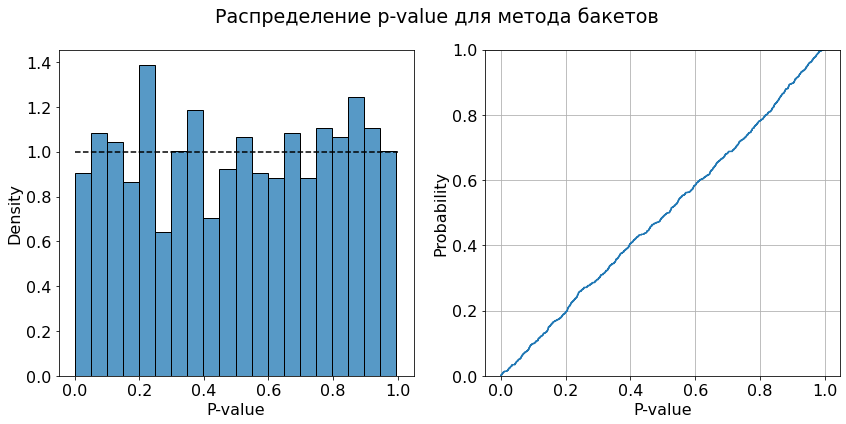

In [111]:
p_values = []

for i in tqdm(range(1000)):
    group_a_dep, group_b_dep = get_AB_groups(i, receipts_generator=get_store_receipts_dependent)
    bucket_a_dep = get_bucket_sum(group_a_dep)
    bucket_b_dep = get_bucket_sum(group_b_dep)
    _, pval = ttest_ind(bucket_a_dep, bucket_b_dep)
    p_values.append(pval)
    
plot_value_ecdf(p_values, title='Распределение p-value для метода бакетов')  

### А зачем нам тут метод бакетов, если можно просто взять продажи по клиентам???

  0%|                                                  | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_6397/2325914427.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probs[idx] = 0.9
100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 69.01it/s]


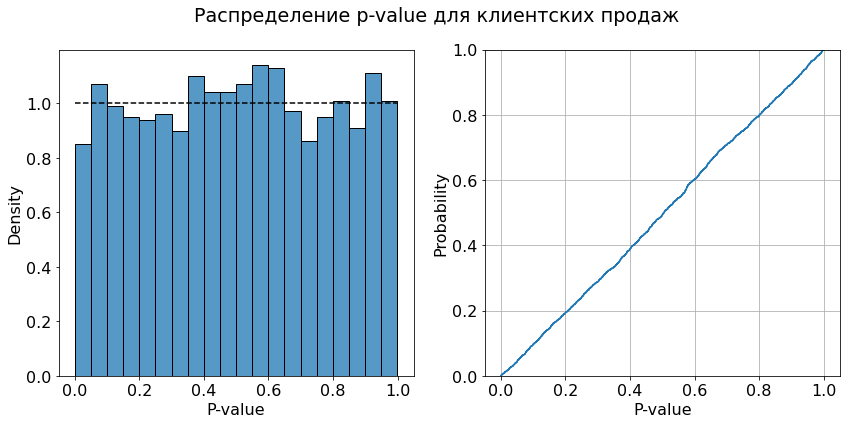

In [130]:
p_values = []

for i in tqdm(range(2000)):
    group_a_dep, group_b_dep = get_AB_groups(i, receipts_generator=get_store_receipts_dependent)
    clients_a_revenue = [store_sales.sum(axis=1) for store_sales in group_a_dep]
    clients_b_revenue = [store_sales.sum(axis=1) for store_sales in group_b_dep]
    _, pval = ttest_ind(np.concatenate(clients_a_revenue), np.concatenate(clients_b_revenue))
    p_values.append(pval)
    
plot_value_ecdf(p_values, title='Распределение p-value для клиентских продаж')  